# Kernel Density Estimation

**Kernel Density Estimation**: non parametric method to estimate the density of a population. offers more accuray than a histogram.

Data points are substituted with a kernel function that specifies how much it influences its neighboring regions.

Kernel functions are summed up to get an estimate of the probability density distribution, similar to summing up data points in bins.

The PDF depends less strongly on the kernel bandwith than histograms to on bin bandwidth

## Definition

Given a set of $n$ sample points $x_k$ ($k = 1,\cdots,n$), kernel density estimation $\widehat{f}_h(x)$ is defined as

\begin{equation}
\widehat{f}_h(x) = \frac{1}{nh} \sum_{k=1}^n K\Big(\frac{x-x_k}{h}\Big)
\end{equation}

where 
- $K(x)$ is called the kernel function, defines the shape and size of influence of a single data point over the estimation. Most typically a simple Gaussian distribution ($K(x) :=\frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}x^2}$) is used as kernel function.
- $h$ is the bandwidth of the kernel, defines the range of influence. The larger the bandwidth parameter $h$ the larger is the range of influence of a single data point on the estimated distribution.
- $x$ is the value for which the estimate is calculated.

### Weights

zfit KDE supports weights


In [1]:
import matplotlib.pyplot as plt
import mplhep
import numpy as np
import zfit

np.random.seed(23)

2022-05-09 22:09:53.547899: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2022-05-09 22:09:53.547977: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-05-09 22:09:56.029175: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-09 22:09:56.029235: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-09 22:09:56.029276: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-KJ9UEOTB): /proc/driver/nvidia/version does not exist
2022-05-09 22:09:56.029688: I tensorflow/core/platform/cpu_fe

## Exact KDE

`KDE1DimExact` Gaussian is not available in zfit=0.5.2, we use instead `GaussianKDE1DimV1`

In [2]:
#Defining observable space
obs_wide = zfit.Space('x', (-10, 10))
#Linspace
x = np.linspace(-10, 10, 200)

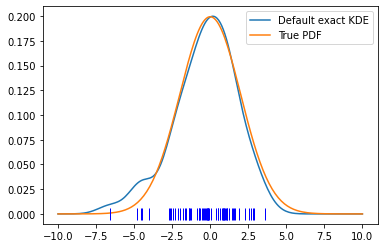

In [3]:
#Creating a Gaussian model with zfit
gauss = zfit.pdf.Gauss(obs=obs_wide, mu=0, sigma=2)
#Creating sample data
sample = gauss.sample(60)
# What is sample_np? Sample in mumpy object
sample_np = zfit.run(sample.value())
# Aplying the KDE to the sampble without obs, kernel, padding, etc.
kde = zfit.pdf.GaussianKDE1DimV1(data = sample, obs = obs_wide)

#Plotting
plt.plot(x, kde.pdf(x), label='Default exact KDE')
plt.plot(x, gauss.pdf(x), label='True PDF')
plt.plot(sample_np, np.zeros_like(sample_np), 'b|', ms=12)
plt.legend()

In [4]:
sample

PDF is overestimated in regions where there are many events and underestimated other regions. 

What about more complex PDFs?

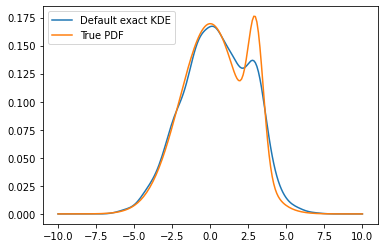

In [5]:
# First gaussian model mu = 0, sigma = 2
gauss1 = zfit.pdf.Gauss(obs=obs_wide, mu=0, sigma=2)
# Second Gaussian model mu = 3, sigma = 0.5
gauss2 = zfit.pdf.Gauss(obs=obs_wide, mu=3, sigma=0.5)
# Summing the two Gaussians
true_pdf = zfit.pdf.SumPDF([gauss1, gauss2], fracs=0.85)

# What is fracs and yield?

sample = true_pdf.sample(1000)
sample_np = zfit.run(sample.value())

# KDE estiamtion
kde = zfit.pdf.GaussianKDE1DimV1(data = sample, obs = obs_wide)

# Plotting
plt.plot(x, kde.pdf(x), label='Default exact KDE')
plt.plot(x, true_pdf.pdf(x), label='True PDF')
plt.legend()

Impossible for the current configuration to aproximate the actual PDF. It uses only a single bandwidth.

## Bandwidth

**Bandwidth** defines the width of the KDE, corresponds to the *sigma* parameter of the Gaussian. There are two tipes of bandwidth:

**Global bandwidth**

Single parameter shared amongst all kernels. Does not take into account different varying local densities.

**Local bandwidth**

Each kernel $i$ has different bandwidth. Given datapoints with size $n$, there is need for $n$ bandwidth parameters. Ofter more accurate than global.

Comparing effects of different bandwidth types:

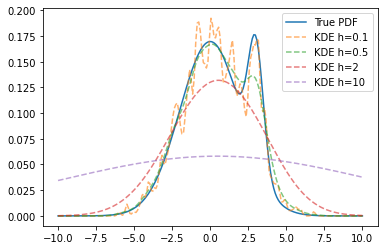

In [6]:
plt.plot(x, true_pdf.pdf(x), label='True PDF')

for h in [0.1, 0.5, 2, 10]:
    kde = zfit.pdf.GaussianKDE1DimV1(data=sample, obs = obs_wide, bandwidth=h)
    plt.plot(x, kde.pdf(x), '--', alpha=0.6, label=f'KDE h={h}')
plt.legend()

- Too small bandwidth size: Peaks and valleys that are not in the original
- Too big bandwith size: Cannot see the two peaks in the sum of Gaussian distributions

Methods to estimate optimal bandwidth

- Silvermans (default)
- Scotts rule of thumb

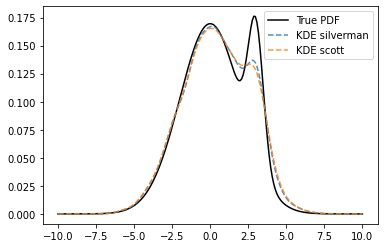

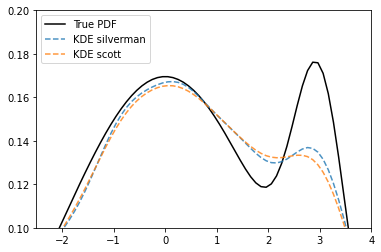

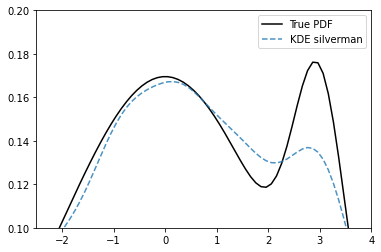

In [7]:
kdes_all = [("silverman", '--'), ("scott", '--')]
# This version does not allow ("adaptive_geom", ':'), and ("adaptive_zfit", ':'), and ("isj", '-.')
kdes_some = [("silverman", '--')]
# This version does not allow , ("adaptive_zfit", ':'), ("isj", '-.') for bandwidth methods
for subplot in range(1, 4):
    plt.figure(subplot)
    if subplot != 1:
        # let's zoom in to better see the details
        plt.xlim(-2.5, 4)
        plt.ylim(0.1, 0.2)
    plt.plot(x, true_pdf.pdf(x), 'k', label='True PDF')
    kdes = kdes_some if subplot == 3 else kdes_all
    for h, fmt in kdes:
        kde = zfit.pdf.GaussianKDE1DimV1(data=sample, obs = obs_wide, bandwidth=h)
        plt.plot(x, kde.pdf(x), fmt, alpha=0.8, label=f'KDE {h}')
    plt.legend()

## Kernel

**Kernel**: Sum of the kernels around each sample point. Represents the distribution probability of a sinble data point.

Most common kernel is Gaussian, but sometimes other alternatives offer a better choice. One can choose from tensorflow_probability.distribution.Distribution

In [8]:
# ! pip list

In [9]:
import tensorflow_probability as tfp

In [10]:
tfd = tfp.distributions

TypeError: __init__() got an unexpected keyword argument 'kernel'

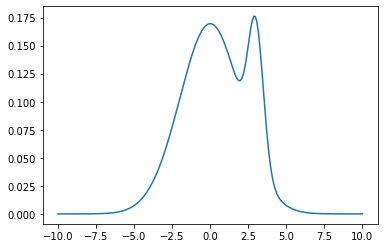

In [27]:
plt.plot(x, true_pdf.pdf(x), label='True PDF')

# This code fails becouse this version of zfit does not have KDE1DimExact, and
# GaussianKDE1DimV1 does not support the argument of 'kernel'.

for kernel in [tfd.Normal, tfd.Cauchy, tfd.Moyal]:
    kde = zfit.pdf.GaussianKDE1DimV1(data = sample, obs = obs_wide, kernel=kernel) 
    #kernel is not a valid argument
    plt.plot(x, kde.pdf(x), '--', alpha=0.6, label=f'KDE {kernel.__name__}')
plt.legend()

# Composite Models

**functors**: `SumPDF` and `ProdPDF`

## SumPDF

In [12]:
frac = zfit.Parameter("frac_gauss", 0.5, 0, 1)

obs1 = zfit.Space('obs1', limits=(-5, 5))

mu1 = zfit.Parameter("mu1", 1.)
sigma1 = zfit.Parameter("sigma1", 1.)
gauss1 = zfit.pdf.Gauss(obs=obs1, mu=mu1, sigma=sigma1)

mu2 = zfit.Parameter("mu2", 1.)
sigma2 = zfit.Parameter("sigma2", 1.)
gauss2 = zfit.pdf.Gauss(obs=obs1, mu=mu2, sigma=sigma2)

In [13]:
# Making the sum
sum_gauss = zfit.pdf.SumPDF(pdfs=[gauss1, gauss2], fracs=frac)

In [14]:
print(sum_gauss.obs)

('obs1',)


Sum has the same observable as daughter PDFs. If they don't coincide, they are combined, and can be used to create higher dimensional PDFs.

## Product PDF

*Example*: 2D product of Gaussians. We can choose between:
- The Python syntax
- The class API

In [15]:
obs2 = zfit.Space('obs2', limits=(-3, 7))
mu3 = zfit.Parameter("mu3", 1.)
sigma3 = zfit.Parameter("sigma3", 1.)
# different obs then above!
gauss3 = zfit.pdf.Gauss(obs=obs2, mu=mu3, sigma=sigma3)  

In [16]:
prod_gauss = zfit.pdf.ProductPDF(pdfs=[gauss1, gauss3])
# notice the different order of the pdfS, they are non-conmutative
prod_gauss_inverted_order = zfit.pdf.ProductPDF(pdfs=[gauss3, gauss1])  

It is also possible to use the syntax: `prod_gauss = gauss1 * gauss3` but it is recommended just for two PDFs.

In [17]:
prod_gauss = gauss1 * gauss3

In [18]:
print("python syntax product obs", prod_gauss.obs)
print("class API product obs", prod_gauss_inverted_order.obs)

python syntax product obs ('obs1', 'obs2')
class API product obs ('obs2', 'obs1')


## Creating an extended PDF

Creation: Using `create_extended(yield_param)` method or with the simple Python syntax of multplying a PDf with the parameter.

In [19]:
yield1 = zfit.Parameter("yield_gauss1", 100, 0, 1000)

In [20]:
extended_gauss_method = gauss3.create_extended(yield1)

- [ ] What is a yield, exactly?

# Binned fits

Creating binned models and data in two ways:

- From an unbinned model to a vinned model or unbinned dataset to a binned one
- Directly from a binned object

In [21]:
! pip install hist

In [22]:
import hist as hist
import mplhep
import numpy as np
import zfit
#import zfit.z.numpy as znp

# The last module is not included in this version of zfit

In [23]:
from matplotlib import pyplot as plt

normal_np = np.random.normal(loc=2., scale=3., size=10000)

obs = zfit.Space("x", limits=(-10, 10))

mu = zfit.Parameter("mu", 1., -4, 6)
sigma = zfit.Parameter("sigma", 1., 0.1, 10)
model_nobin = zfit.pdf.Gauss(mu, sigma, obs)

data_nobin = zfit.Data.from_numpy(obs, normal_np)

loss_nobin = zfit.loss.UnbinnedNLL(model_nobin, data_nobin)

In [26]:
# make binned

binning = zfit.binned.RegularBinning(50, -8, 10, name="x")

# This doesn't work since zfit.binned is not a module in the
# current version of zfit.

AttributeError: module 'zfit' has no attribute 'binned'

# Custom Code with zfit

# Creating your own PDF

# Multidimensional PDFs

# Toy Studies